In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go

%matplotlib inline
from datetime import datetime

# Set figure size and style for seaborn
rcParams['figure.figsize'] = 12, 6
sns.set(style='whitegrid')

# No need to import CuDNNLSTM anymore
# LSTM layer will automatically use the CuDNN kernel when conditions are met

# Example: Define a simple Sequential model with LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(None, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [2]:
# Covert data to dataframe
file_path = '/Users/moritzrichter/Desktop/cryptocurrency_analysis/data/Coins/All_coins_fiveyears_sorted.csv'

# Load the dataset from the specified file path
crypto_df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to ensure it has loaded correctly
crypto_df.head()

Name        Date         High          Low         Open  \
0       Bitcoin  2019-04-17  5285.269355  5083.122626  5110.364743   
1        Ripple  2019-04-17     0.331138     0.321118     0.323991   
2      Ethereum  2019-04-17   169.793896   162.671355   163.085245   
3  Binance_Coin  2019-04-17    20.142752    18.985843    19.502150   
4       Cardano  2019-04-17     0.084724     0.081028     0.083096   

         Close        Volume     Marketcap  
0  5280.621478  1.122892e+10  9.101929e+10  
1     0.331138  7.564794e+08  1.362860e+10  
2   169.793896  4.349636e+09  1.747363e+10  
3    20.055316  1.649055e+08  2.760849e+09  
4     0.084645  1.009852e+08  2.153132e+09

In [3]:
# Display rows where 'Date' is NaT
print(crypto_df[crypto_df['Date'].isna()])

Empty DataFrame
Columns: [Name, Date, High, Low, Open, Close, Volume, Marketcap]
Index: []


In [4]:
# Check no null value in crypto_df
crypto_df.isna().sum()

Name         0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

In [5]:
crypto_df.dtypes

Name          object
Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object

In [6]:
# Check unique formats of date entries to spot inconsistencies
print(crypto_df['Date'].unique())

# Try converting the 'Date' column with a specific format
# Adjust the format string according to what you find in your data
crypto_df['Date'] = pd.to_datetime(crypto_df['Date'], format='%Y-%m-%d', errors='coerce')

# Check for entries that couldn't be converted
print(crypto_df[crypto_df['Date'].isna()])

['2019-04-17' '2019-04-18' '2019-04-19' ... '2024-04-12' '2024-04-13'
 '2024-04-14']
Empty DataFrame
Columns: [Name, Date, High, Low, Open, Close, Volume, Marketcap]
Index: []


In [19]:
# For Bitcoin
btc = crypto_df[crypto_df['Name'] == 'Bitcoin']

# Convert 'Date' to datetime format to ensure proper chronological sorting
btc['Date'] = pd.to_datetime(btc['Date'])

# Set 'Date' as the index of the DataFrame
btc.set_index('Date', inplace=True)

# Now, when you call head(), it will show 'Date' as the index
print(btc.head())

               Name         High          Low         Open        Close  \
Date                                                                      
2019-04-17  Bitcoin  5285.269355  5083.122626  5110.364743  5280.621478   
2019-04-18  Bitcoin  5309.767053  5247.411896  5274.409619  5271.109695   
2019-04-19  Bitcoin  5330.747550  5268.381876  5271.352176  5309.256996   
2019-04-20  Bitcoin  5349.185233  5253.519639  5308.334719  5317.962150   
2019-04-21  Bitcoin  5372.559483  5314.995062  5318.985321  5363.756655   

                  Volume     Marketcap  
Date                                    
2019-04-17  1.122892e+10  9.101929e+10  
2019-04-18  1.171812e+10  9.299844e+10  
2019-04-19  1.106357e+10  9.346719e+10  
2019-04-20  1.072242e+10  9.345605e+10  
2019-04-21  1.208157e+10  9.440771e+10  


/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/3466058019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['Date'] = pd.to_datetime(btc['Date'])


In [21]:
# For Cardano
ada = crypto_df[crypto_df['Name'] == 'Cardano']

# Make sure to convert the 'Date' column of ada, not btc
ada['Date'] = pd.to_datetime(ada['Date'])

# Set 'Date' as the index of the DataFrame
ada.set_index('Date', inplace=True)

# Now, when you call head(), it will show 'Date' as the index
print(ada.head())

               Name      High       Low      Open     Close        Volume  \
Date                                                                        
2019-04-17  Cardano  0.084724  0.081028  0.083096  0.084645  1.009852e+08   
2019-04-18  Cardano  0.084992  0.082735  0.084550  0.083647  9.266402e+07   
2019-04-19  Cardano  0.084465  0.081675  0.083719  0.082058  9.340067e+07   
2019-04-20  Cardano  0.082082  0.078741  0.082082  0.079886  1.144789e+08   
2019-04-21  Cardano  0.079887  0.075924  0.079821  0.076902  1.060710e+08   

               Marketcap  
Date                      
2019-04-17  2.153132e+09  
2019-04-18  2.169354e+09  
2019-04-19  2.158388e+09  
2019-04-20  2.066557e+09  
2019-04-21  2.024528e+09  


/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/3827552396.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ada['Date'] = pd.to_datetime(ada['Date'])


In [22]:
# For Binance
bnb = crypto_df[crypto_df['Name'] == 'Binance_Coin']

# Convert 'Date' to datetime format to ensure proper chronological sorting
bnb['Date'] = pd.to_datetime(bnb['Date'])

# Set 'Date' as the index of the DataFrame
bnb.set_index('Date', inplace=True)

# Display the first few rows to ensure it's loaded and indexed correctly
print(bnb.head())

                    Name       High        Low       Open      Close  \
Date                                                                   
2019-04-17  Binance_Coin  20.142752  18.985843  19.502150  20.055316   
2019-04-18  Binance_Coin  20.107065  19.688879  20.036108  19.787136   
2019-04-19  Binance_Coin  22.257706  19.729968  19.790795  22.195677   
2019-04-20  Binance_Coin  24.884916  21.512709  22.159322  24.541845   
2019-04-21  Binance_Coin  25.583658  24.070025  24.579824  25.147023   

                  Volume     Marketcap  
Date                                    
2019-04-17  1.649055e+08  2.760849e+09  
2019-04-18  1.558340e+08  2.801093e+09  
2019-04-19  2.988409e+08  2.980958e+09  
2019-04-20  3.856008e+08  3.241708e+09  
2019-04-21  3.945320e+08  3.503405e+09  


/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/4039988288.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bnb['Date'] = pd.to_datetime(bnb['Date'])


In [23]:
# For Ethereum
eth = crypto_df[crypto_df['Name'] == 'Ethereum']

# Convert 'Date' to datetime format to ensure proper chronological sorting
eth['Date'] = pd.to_datetime(eth['Date'])

# Set 'Date' as the index of the DataFrame
eth.set_index('Date', inplace=True)

# Now, when you call head(), it will show 'Date' as the index
print(eth.head())

                Name        High         Low        Open       Close  \
Date                                                                   
2019-04-17  Ethereum  169.793896  162.671355  163.085245  169.793896   
2019-04-18  Ethereum  170.759335  167.288903  169.485605  168.445130   
2019-04-19  Ethereum  176.325867  168.036023  168.402685  174.767110   
2019-04-20  Ethereum  175.010126  171.873865  174.901697  174.800910   
2019-04-21  Ethereum  177.250340  173.480841  174.860856  175.282926   

                  Volume     Marketcap  
Date                                    
2019-04-17  4.349636e+09  1.747363e+10  
2019-04-18  4.252172e+09  1.779057e+10  
2019-04-19  4.994551e+09  1.833714e+10  
2019-04-20  5.053026e+09  1.838350e+10  
2019-04-21  4.891869e+09  1.851742e+10  


/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/3963690699.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth['Date'] = pd.to_datetime(eth['Date'])


In [24]:
# For Polkadot_(DOT)
dot = crypto_df[crypto_df['Name'] == 'Polkadot']

# Convert 'Date' to datetime format to ensure proper chronological sorting
dot['Date'] = pd.to_datetime(dot['Date'])

# Set 'Date' as the index of the DataFrame
dot.set_index('Date', inplace=True)

# Display the first few rows to ensure it's loaded and indexed correctly
print(dot.head())

                Name      High       Low      Open     Close        Volume  \
Date                                                                         
2020-08-22  Polkadot  3.030000  2.857274  2.936117  2.878794  5.314102e+07   
2020-08-23  Polkadot  4.518678  2.822951  2.867354  4.477365  1.810368e+08   
2020-08-24  Polkadot  4.486948  3.731285  4.486948  3.974245  3.623563e+08   
2020-08-25  Polkadot  4.766288  3.820481  3.990420  4.552361  2.745461e+08   
2020-08-26  Polkadot  5.739077  4.501397  4.571726  5.469447  7.595200e+08   

               Marketcap  
Date                      
2020-08-22  0.000000e+00  
2020-08-23  0.000000e+00  
2020-08-24  0.000000e+00  
2020-08-25  0.000000e+00  
2020-08-26  4.561539e+09  


/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/3645532681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dot['Date'] = pd.to_datetime(dot['Date'])


In [25]:
# For Ripple_(XRP)
xrp = crypto_df[crypto_df['Name'] == 'Ripple']

# Convert 'Date' to datetime format to ensure proper chronological sorting
xrp['Date'] = pd.to_datetime(xrp['Date'])

# Set 'Date' as the index of the DataFrame
xrp.set_index('Date', inplace=True)

# Display the first few rows to ensure it's loaded and indexed correctly
print(xrp.head())

              Name      High       Low      Open     Close        Volume  \
Date                                                                       
2019-04-17  Ripple  0.331138  0.321118  0.323991  0.331138  7.564794e+08   
2019-04-18  Ripple  0.342660  0.324983  0.330490  0.337951  8.383319e+08   
2019-04-19  Ripple  0.347958  0.336499  0.338288  0.338405  1.132520e+09   
2019-04-20  Ripple  0.338381  0.331285  0.338381  0.334124  9.343012e+08   
2019-04-21  Ripple  0.335609  0.327818  0.334186  0.331460  7.643931e+08   

               Marketcap  
Date                      
2019-04-17  1.362860e+10  
2019-04-18  1.391597e+10  
2019-04-19  1.427482e+10  
2019-04-20  1.402296e+10  
2019-04-21  1.398374e+10  


/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/4156352181.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xrp['Date'] = pd.to_datetime(xrp['Date'])


In [26]:
# For Solana_SOL
sol = crypto_df[crypto_df['Name'] == 'Solana']

# Convert 'Date' to datetime format to ensure proper chronological sorting
sol['Date'] = pd.to_datetime(sol['Date'])

# Set 'Date' as the index of the DataFrame
sol.set_index('Date', inplace=True)

# Display the first few rows to ensure it's loaded and indexed correctly
print(sol.head())

              Name      High       Low      Open     Close        Volume  \
Date                                                                       
2020-04-10  Solana  0.744465  0.587102  0.663252  0.689381  1.313219e+06   
2020-04-11  Solana  1.299801  0.609707  0.687634  0.946813  3.981549e+07   
2020-04-12  Solana  1.049920  0.768842  0.947323  0.777010  8.071966e+07   
2020-04-13  Solana  0.959297  0.763816  0.785999  0.896545  4.235095e+07   
2020-04-14  Solana  0.879706  0.776557  0.879706  0.776557  2.837542e+07   

            Marketcap  
Date                   
2020-04-10        0.0  
2020-04-11        0.0  
2020-04-12        0.0  
2020-04-13        0.0  
2020-04-14        0.0  


/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/549775594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol['Date'] = pd.to_datetime(sol['Date'])


In [27]:
def to2021(df):
    df21=equalize(df,bit)
    return df21.iloc[:len(bit21)]

def equalize(df,dfs):
    low=len(dfs)
    high=len(df)
    dff=high-low
    
    return df.iloc[dff:]

/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/3349974657.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot =  sns.lineplot(data=cryptoDf[i], x="Date", y="Close",color='#732C2C',palette ='coolwarm',ax=axs[row][pos])
/Users/moritzrichter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/moritzrichter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/3349974657.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.

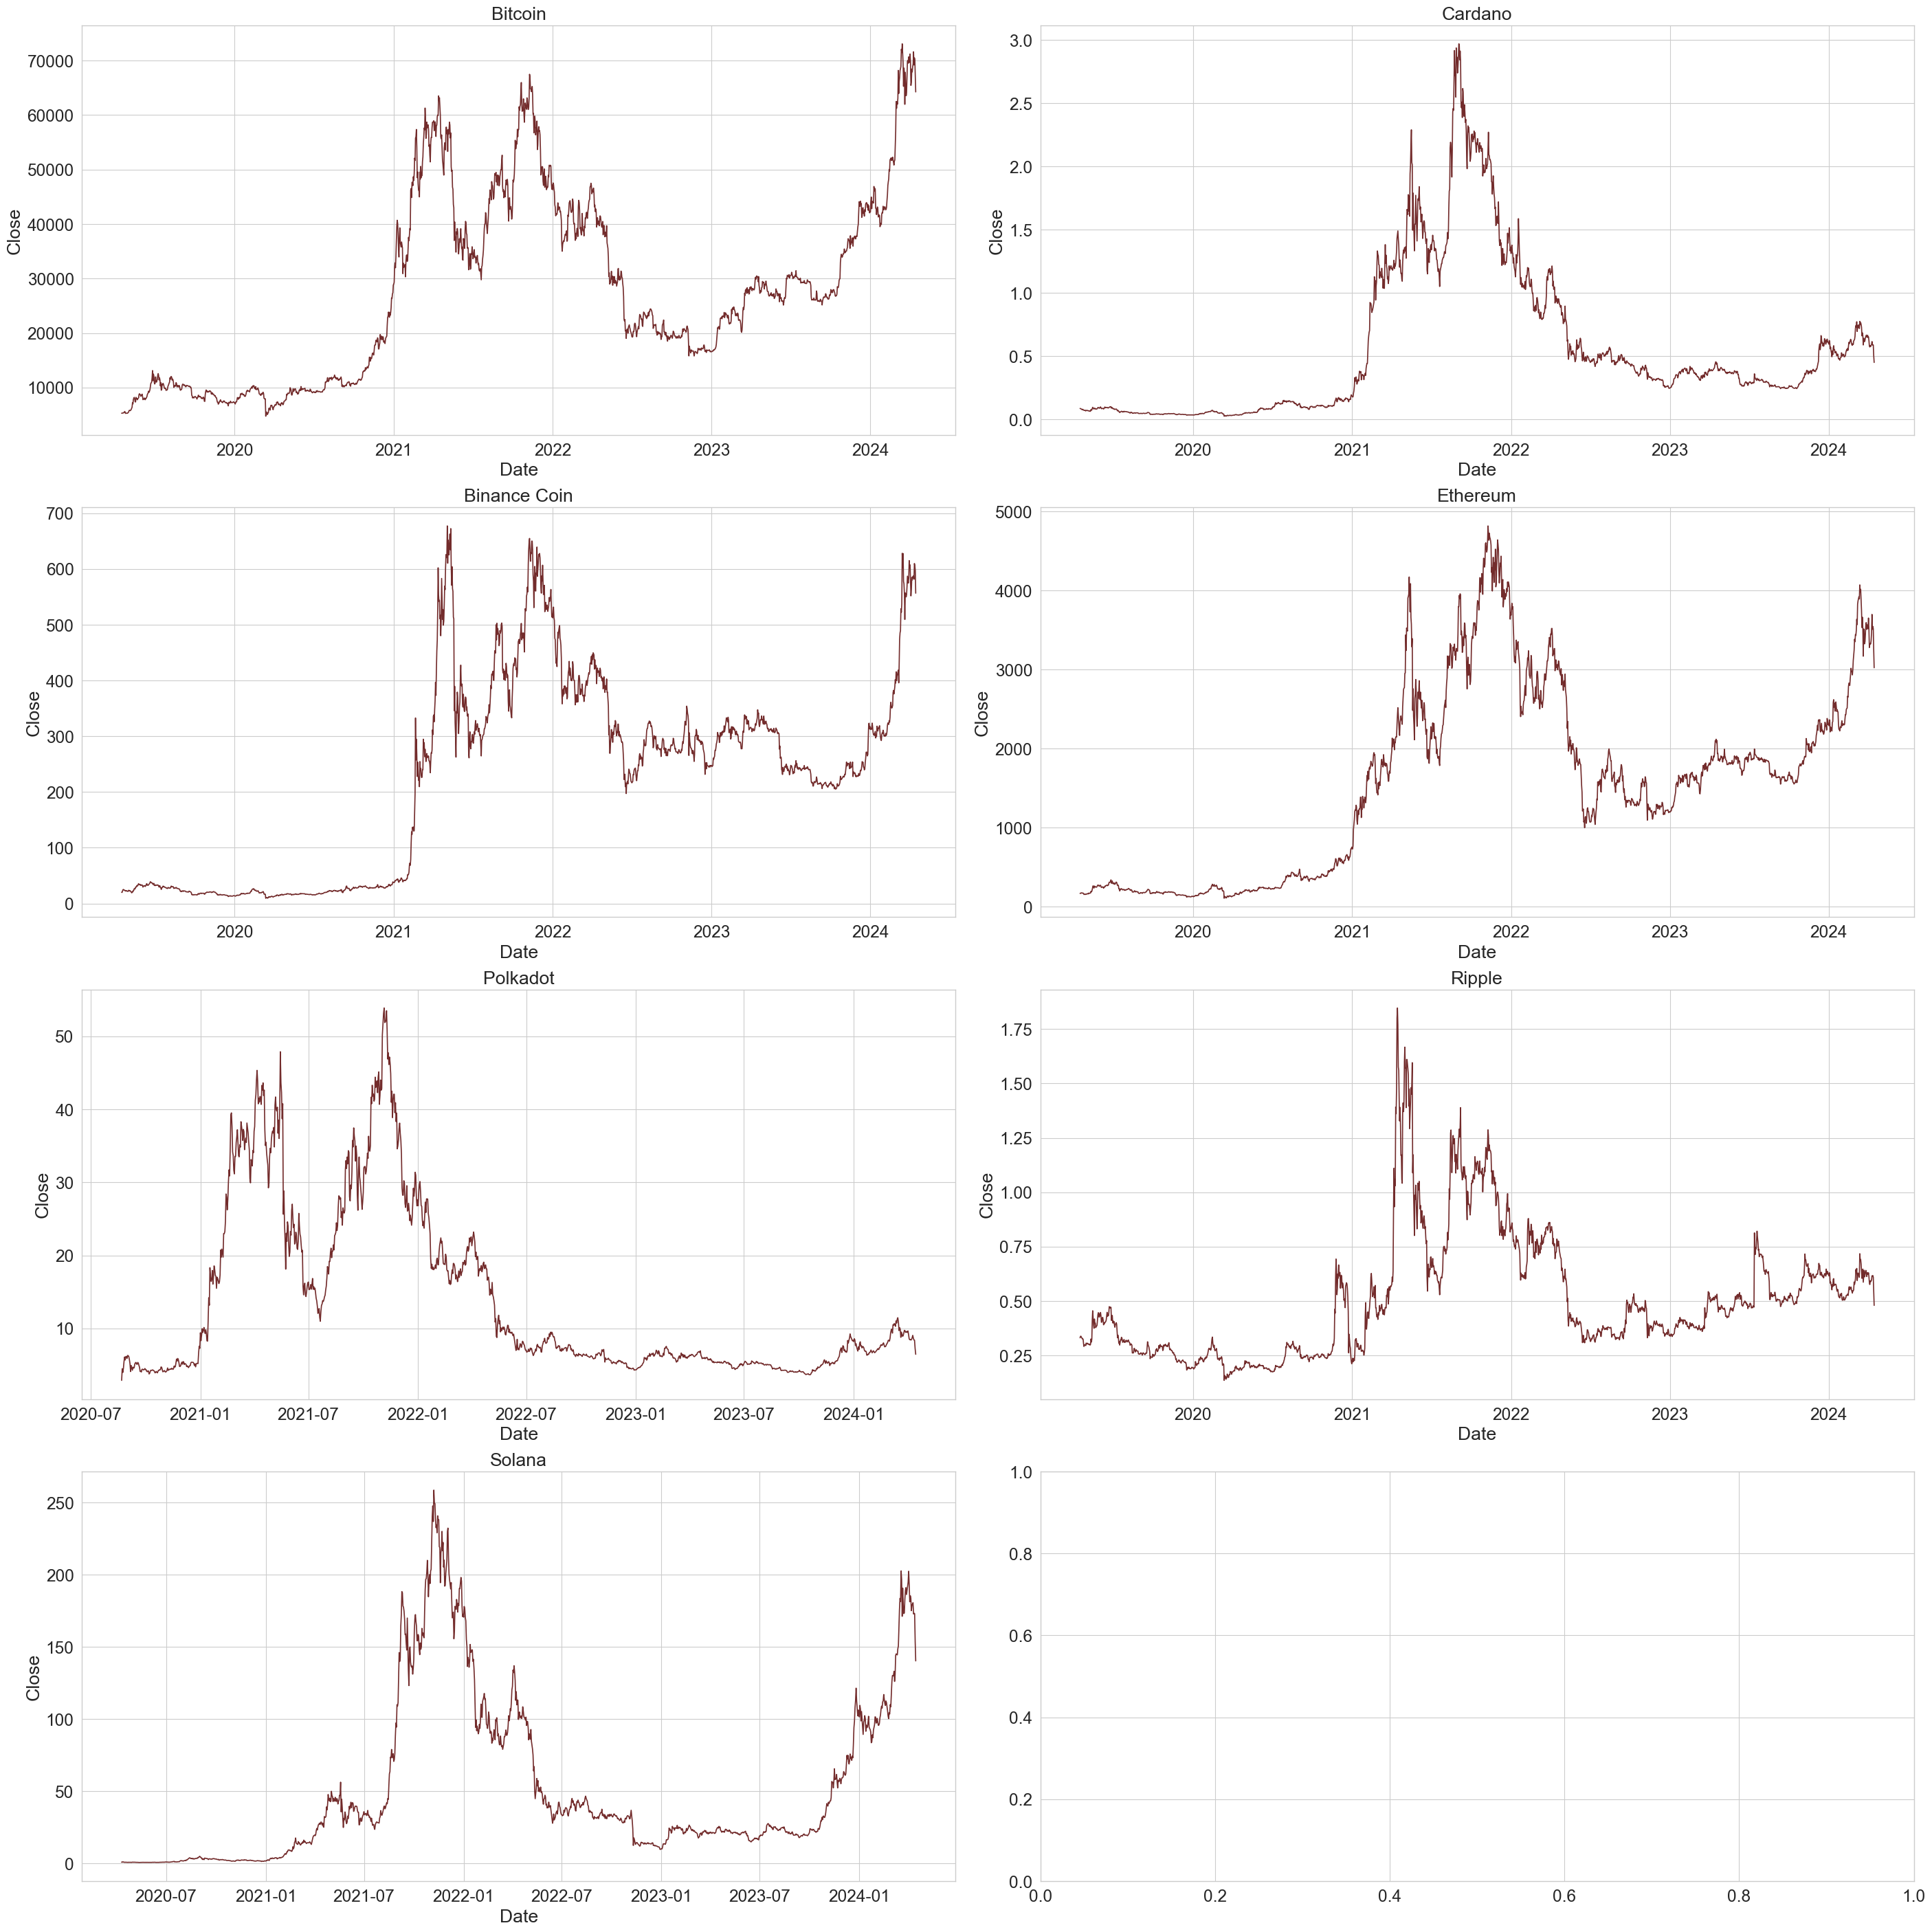

In [28]:
# Lineplot for each coin
crypto=["Bitcoin","Cardano","Binance Coin","Ethereum","Polkadot","Ripple","Solana"]
cryptoDf=[btc,ada,bnb,eth,dot,xrp,sol]
num_plots = 7
total_cols = 2
total_rows = 4
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(14*total_cols, 7*total_rows), constrained_layout=True)
for i, var in enumerate(crypto):
    row = i//total_cols
    pos = i % total_cols
    sns.set_context('paper', font_scale = 2)
    plot =  sns.lineplot(data=cryptoDf[i], x="Date", y="Close",color='#732C2C',palette ='coolwarm',ax=axs[row][pos])
    axs[row][pos].set_title(crypto[i])

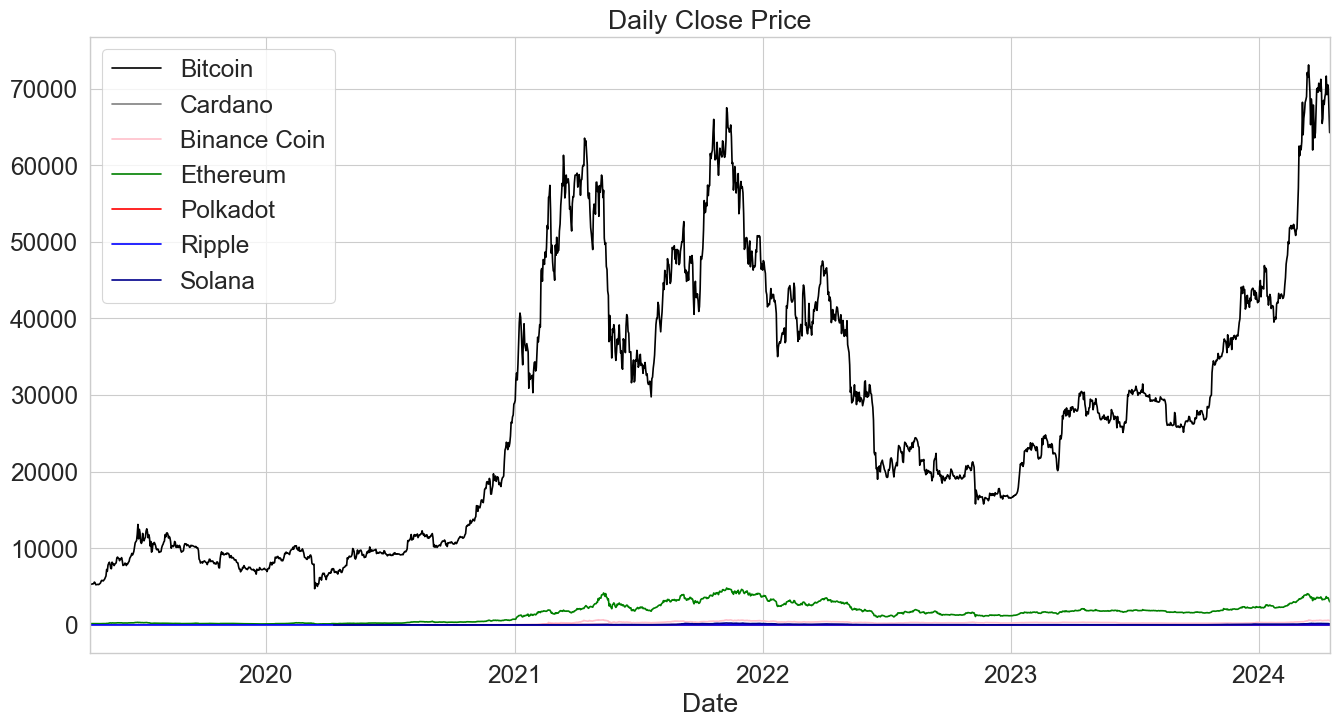

In [29]:
# Combine daily close price of all coins in one chart
plt.figure(figsize=(16,8))
btc['Close'].plot(label='Bitcoin', color="black")
ada['Close'].plot(label='Cardano', color="gray")
bnb['Close'].plot(label='Binance Coin', color="pink")
eth['Close'].plot(label='Ethereum', color="green")
dot['Close'].plot(label='Polkadot', color="red")
xrp['Close'].plot(label='Ripple', color="blue")
sol['Close'].plot(label='Solana', color="darkblue")

plt.title("Daily Close Price")
plt.xlabel('Date')
plt.legend()

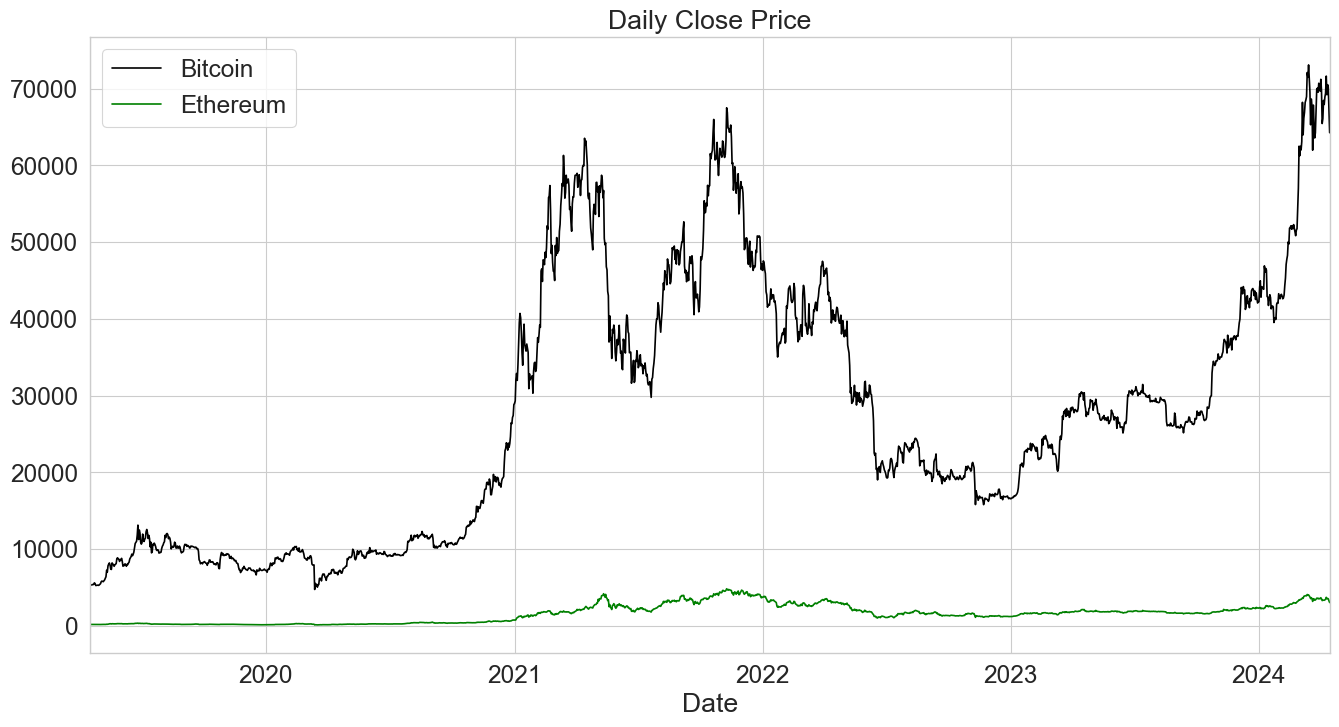

In [30]:
plt.figure(figsize=(16,8))
btc['Close'].plot(label='Bitcoin', color="black")
eth['Close'].plot(label='Ethereum', color="green")


plt.title("Daily Close Price")
plt.xlabel('Date')
plt.legend()

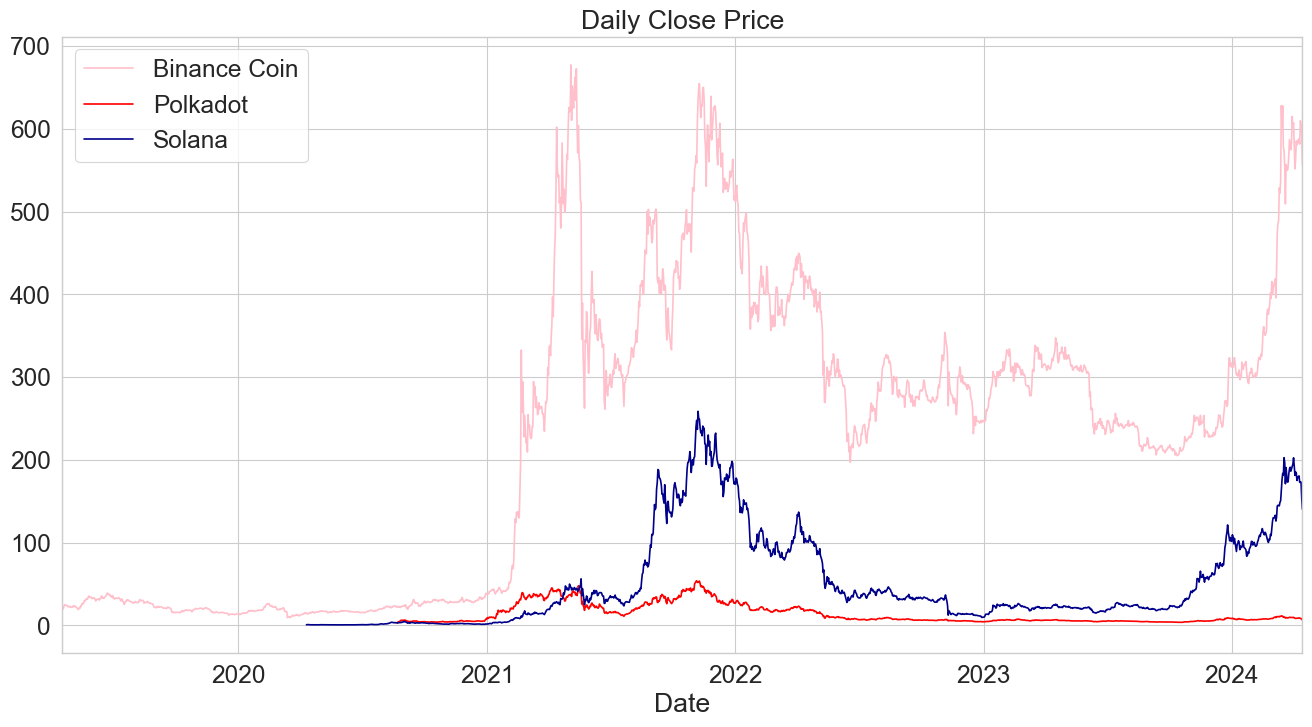

In [33]:
plt.figure(figsize=(16,8))

bnb['Close'].plot(label='Binance Coin', color="pink")
dot['Close'].plot(label='Polkadot', color="red")
sol['Close'].plot(label='Solana', color="darkblue")


plt.title("Daily Close Price")
plt.xlabel('Date')
plt.legend()

/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/503961212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Daily_Return'] = df['Close'].pct_change()
/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/503961212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Daily_Return'] = df['Close'].pct_change()
/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/503961212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

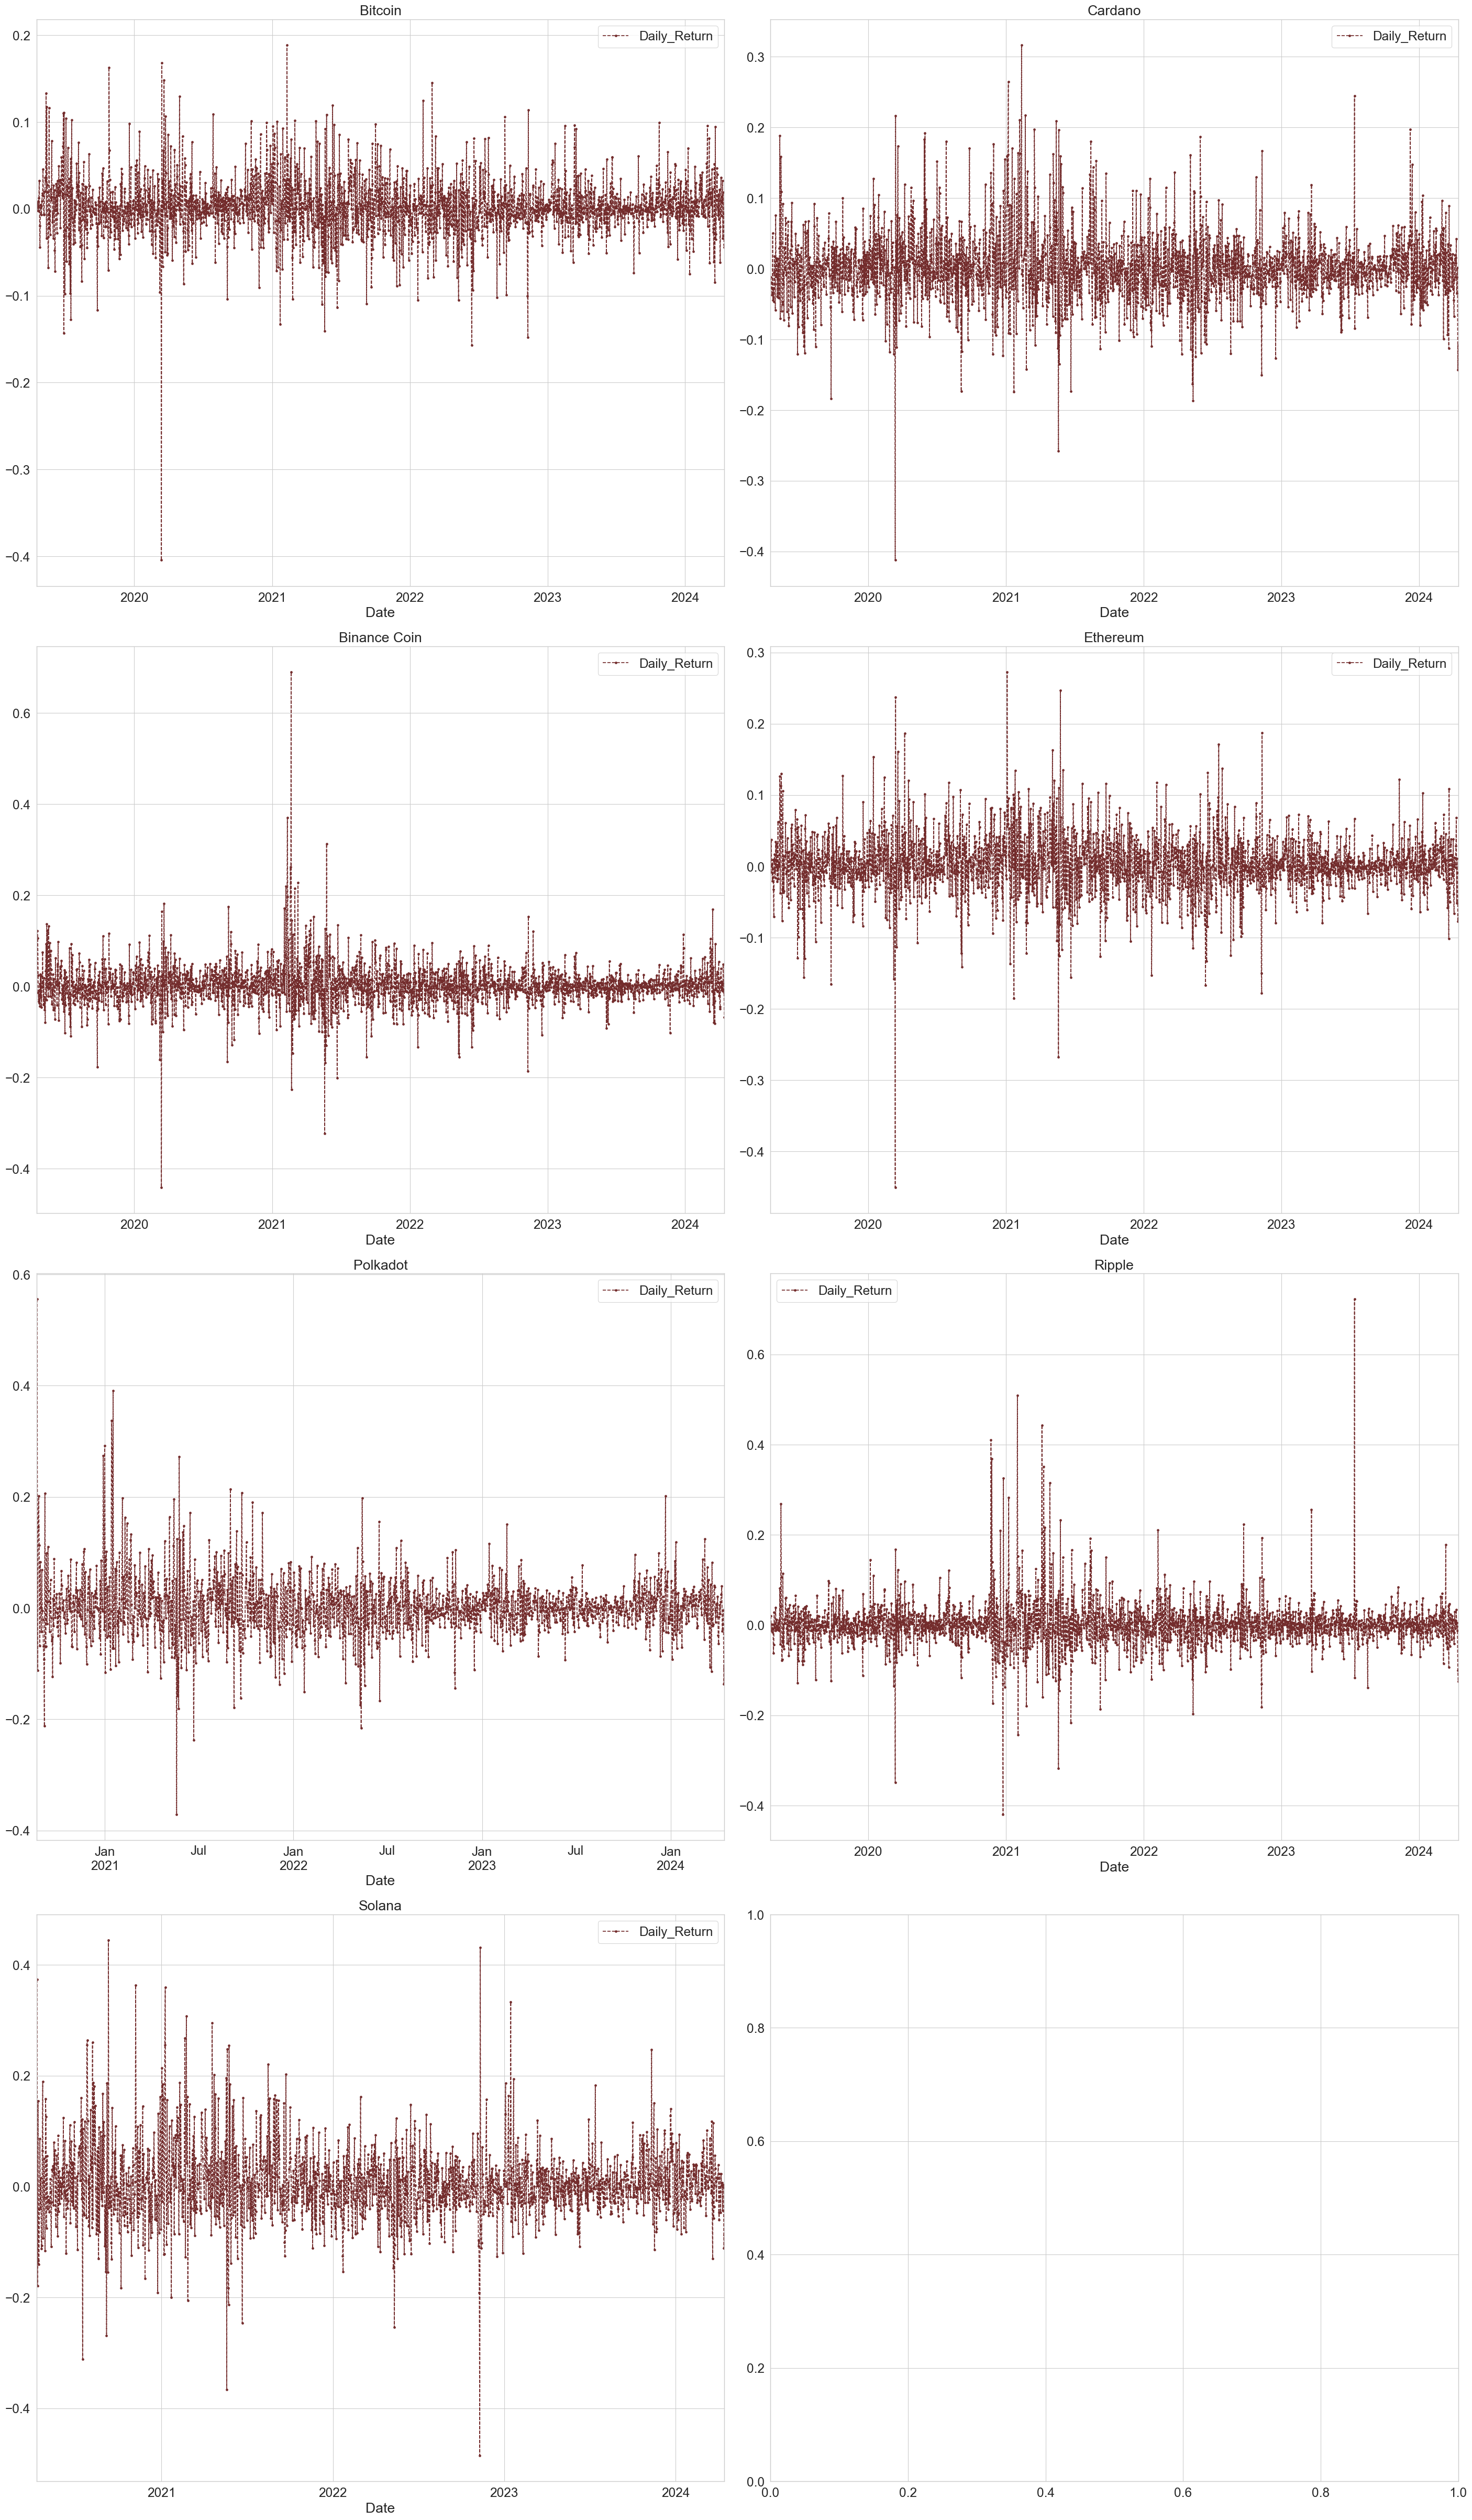

In [34]:
for df in cryptoDf:
    df['Daily_Return'] = df['Close'].pct_change()
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(14*total_cols, 12*total_rows), constrained_layout=True)
for i, var in enumerate(crypto):
    row = i//total_cols
    pos = i % total_cols
    cryptoDf[i]['Daily_Return'].plot(ax=axs[row][pos], legend=True,color='#732C2C', linestyle='--', marker='.')
    axs[row][pos].set_title(crypto[i])

/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/1959117773.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot =sns.distplot(cryptoDf[i]['Daily_Return'], bins=100, color='#732C2C',ax=axs[row][pos])
/Users/moritzrichter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/1959117773.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in se

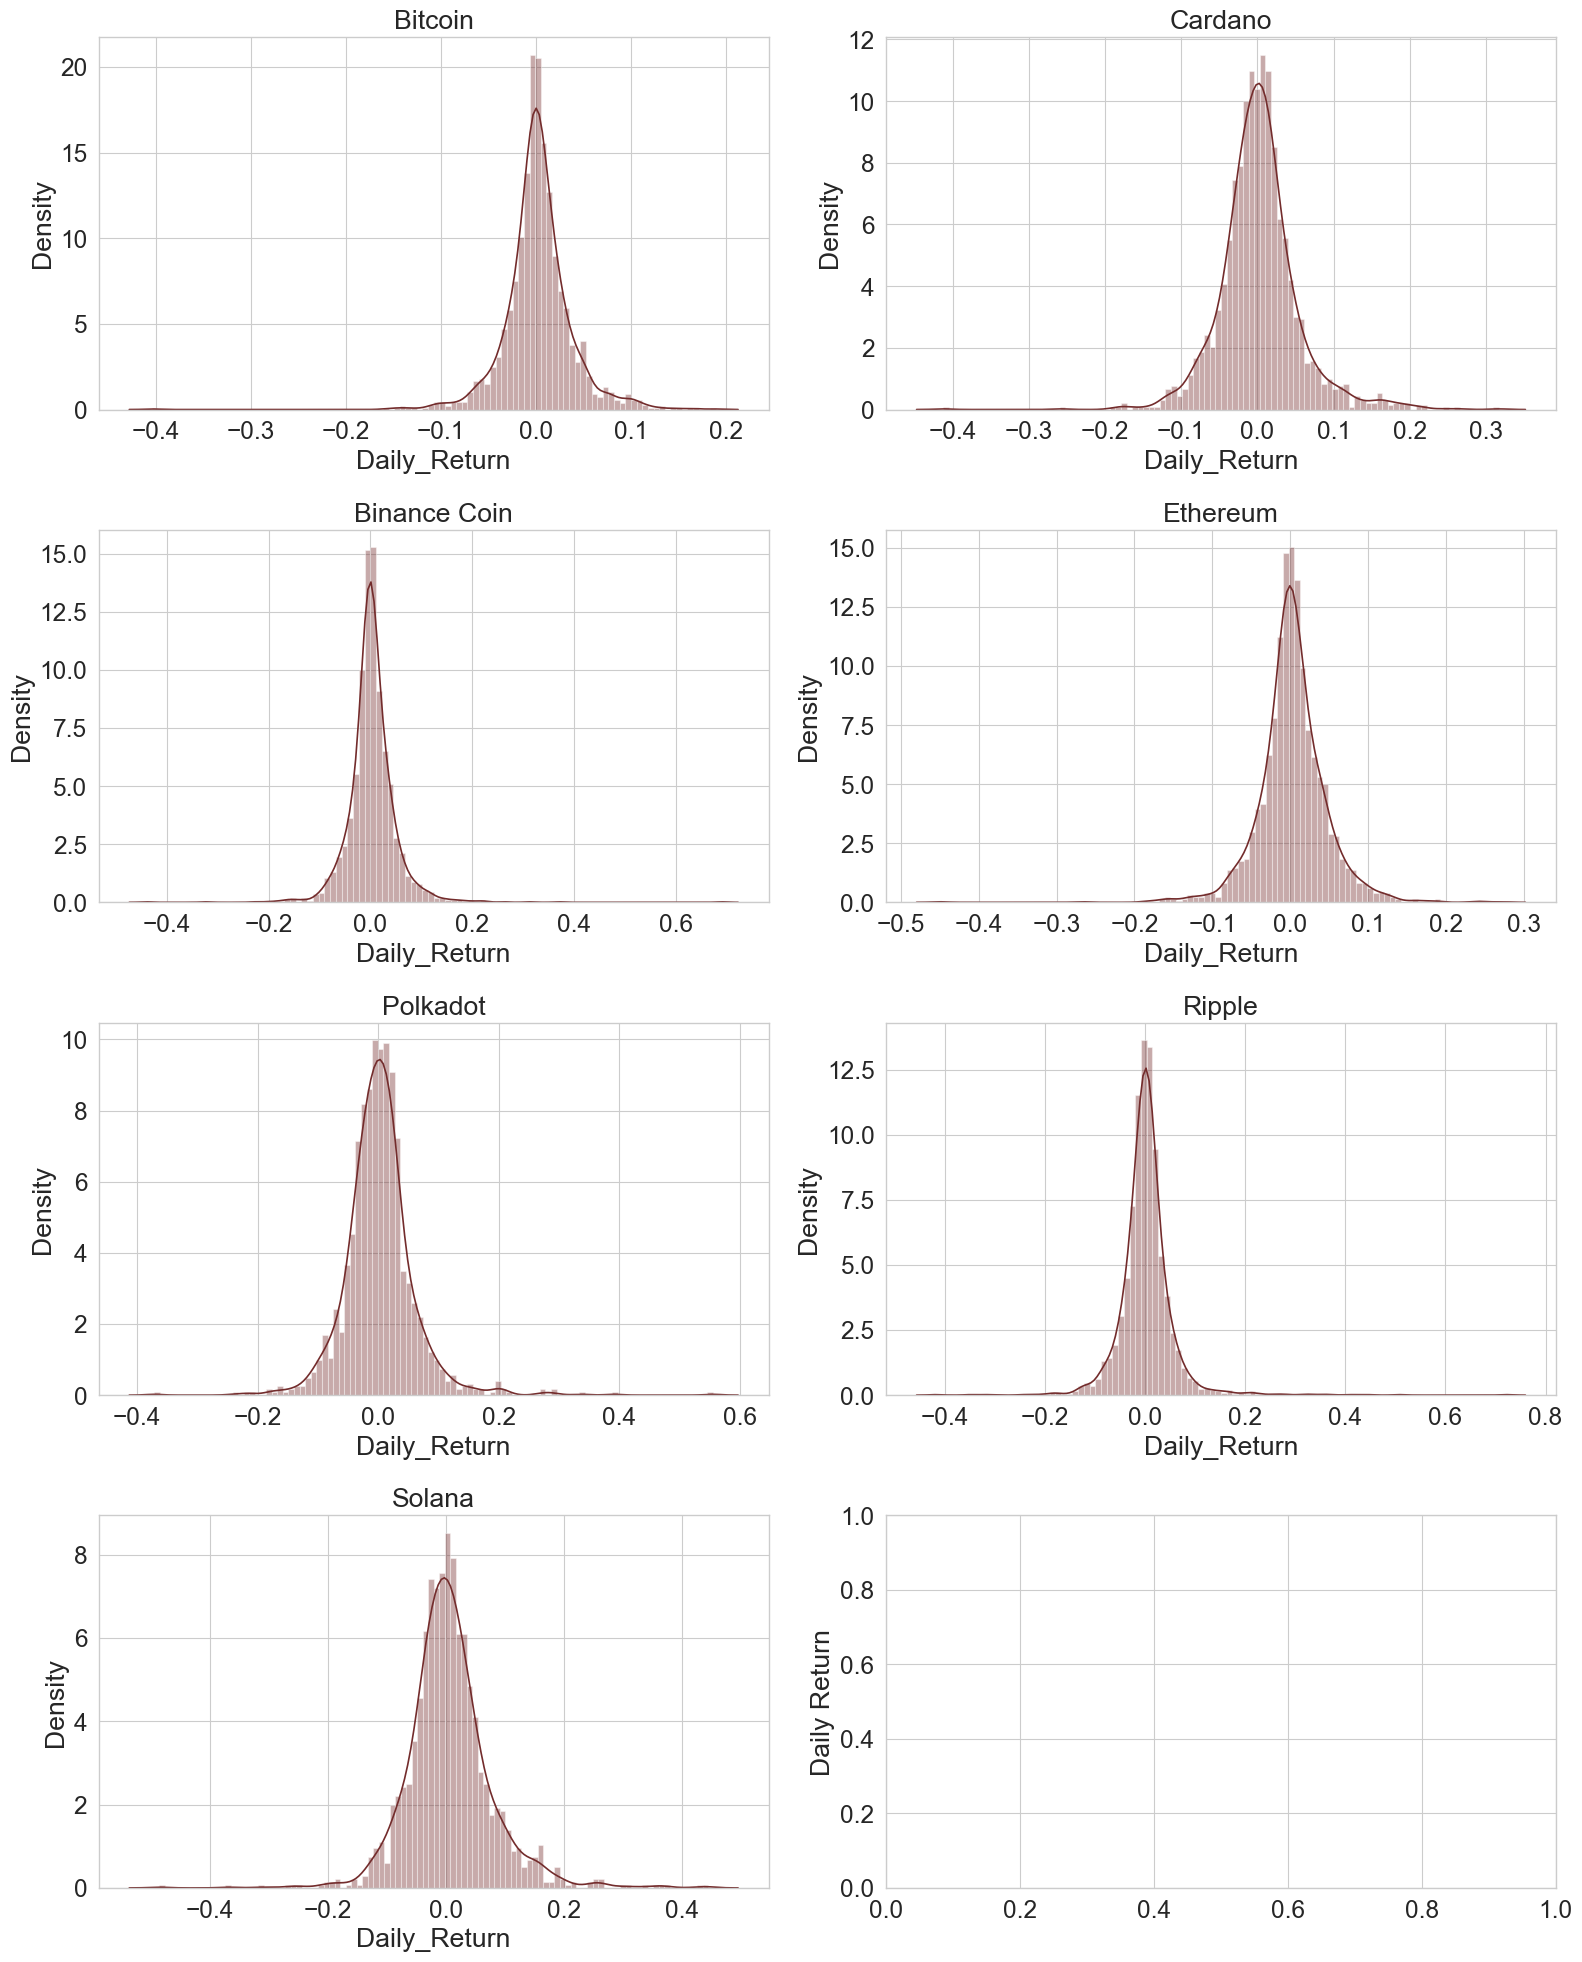

In [35]:
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(8*total_cols, 5*total_rows))
for i, var in enumerate(crypto):
    row = i//total_cols
    pos = i % total_cols
    plot =sns.distplot(cryptoDf[i]['Daily_Return'], bins=100, color='#732C2C',ax=axs[row][pos])
    axs[row][pos].set_title(crypto[i])
    plt.ylabel('Daily Return')

plt.tight_layout()

In [37]:
closeDf=pd.DataFrame()
closeDf['btc']=btc['Close']
closeDf['ada']=ada['Close']
closeDf['bnb']=bnb['Close']
closeDf['eth']=eth['Close']
closeDf['dot']=dot['Close']
closeDf['xrp']=xrp['Close']
closeDf['sol']=sol['Close']
returns = closeDf.pct_change()
returns.head()

btc       ada       bnb       eth  dot       xrp  sol
Date                                                                  
2019-04-17       NaN       NaN       NaN       NaN  NaN       NaN  NaN
2019-04-18 -0.001801 -0.011791 -0.013372 -0.007944  NaN  0.020575  NaN
2019-04-19  0.007237 -0.018988  0.121723  0.037531  NaN  0.001343  NaN
2019-04-20  0.001640 -0.026479  0.105704  0.000193  NaN -0.012649  NaN
2019-04-21  0.008611 -0.037352  0.024659  0.002758  NaN -0.007974  NaN

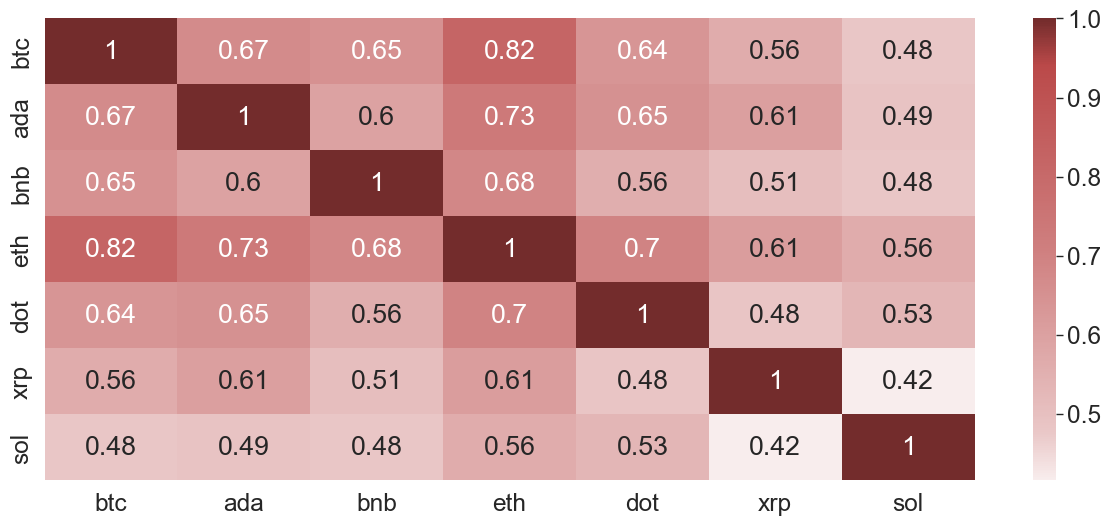

In [38]:
# Create heatmap for correlation of each coin
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

hc = ['#F8EDED', '#EAC8C8', '#CF7F7F', '#BA4949', '#732C2C']
th = [0, 0.1, 0.5, 0.9, 1]

cdict = NonLinCdict(th, hc)
cm = LinearSegmentedColormap('test', cdict)
plt.figure(figsize=(15,6))
sns.heatmap(returns.corr(), annot=True, cmap=cm)
plt.show()

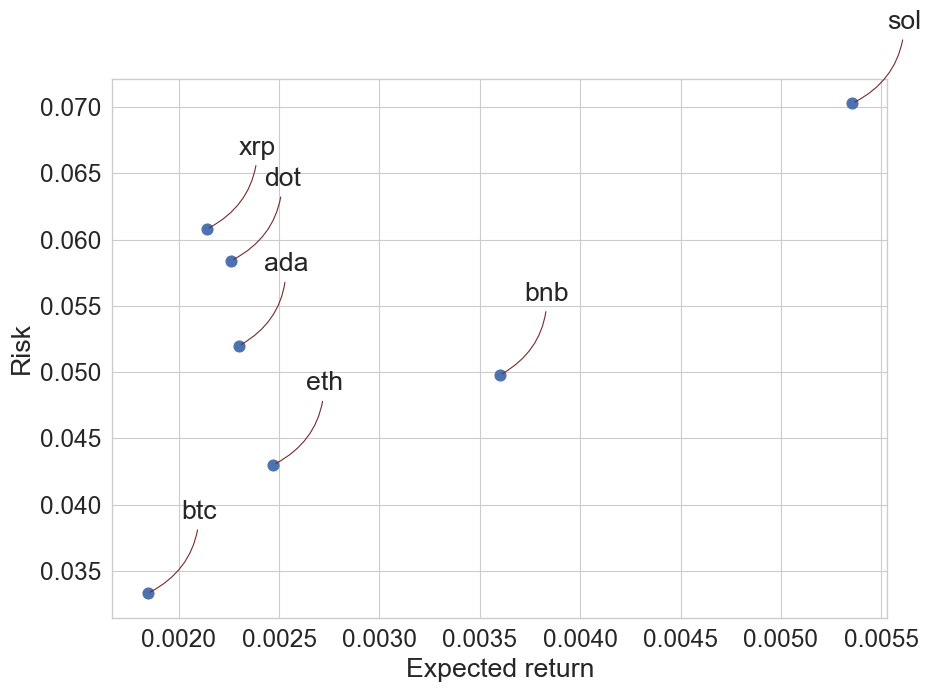

In [39]:
rets = returns.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 7))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='#732C2C', connectionstyle='arc3,rad=-0.3'))

In [40]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [41]:
# Select some input features from the trading data: 
# 5 min log return, abs(5 min log return), upper shadow, and lower shadow.
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

X_btc = pd.concat([log_return(btc.Open,periods=5), log_return(btc.Open,periods=1).abs(), 
               upper_shadow(btc), lower_shadow(btc)], axis=1)
y_btc = btc.Close

X_eth = pd.concat([log_return(eth.Open,periods=5), log_return(eth.Open,periods=1).abs(), 
               upper_shadow(eth), lower_shadow(eth)], axis=1)
y_eth = eth.Close

In [42]:
# select training and test periods
train_window = [("07/06/2019"), ("07/06/2020")]
test_window = [("07/06/2020"), ("07/06/2021")]

# divide data into train and test, compute X and y
# we aim to build simple regression models using a window_size of 1
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

In [43]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

In [44]:
from sklearn.linear_model import LinearRegression

# implement basic ML baseline (one per asset)
lr = LinearRegression()
lr.fit(X_btc_train_scaled,y_btc_train)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

lr.fit(X_eth_train_scaled,y_eth_train)
y_pred_lr_eth = lr.predict(X_eth_test_scaled)

In [45]:
# implement more complex baseline (multiple input/output regression model)
from sklearn.multioutput import MultiOutputRegressor

# we concatenate X and y for both assets
X_both_train = np.concatenate((X_btc_train_scaled, X_eth_train_scaled), axis=1)
X_both_test = np.concatenate((X_btc_test_scaled, X_eth_test_scaled), axis=1)
y_both_train = np.column_stack((y_btc_train, y_eth_train))
y_both_test = np.column_stack((y_btc_test, y_eth_test))

# define the direct multioutput model and fit it
mlr = MultiOutputRegressor(LinearRegression())
mlr.fit(X_both_train,y_both_train)
y_pred_lr_both = mlr.predict(X_both_test)

In [46]:
print('Test score for LR baseline: BTC', f"{np.corrcoef(y_pred_lr_btc, y_btc_test)[0,1]:.2f}", 
                                ', ETH', f"{np.corrcoef(y_pred_lr_eth, y_eth_test)[0,1]:.2f}")
print('Test score for multiple output LR baseline: BTC', f"{np.corrcoef(y_pred_lr_both[:,0], y_btc_test)[0,1]:.2f}", 
                                                ', ETH', f"{np.corrcoef(y_pred_lr_both[:,1], y_eth_test)[0,1]:.2f}")

Test score for LR baseline: BTC 0.53 , ETH 0.64
Test score for multiple output LR baseline: BTC 0.48 , ETH 0.62


In [47]:
from sklearn.model_selection import train_test_split
for col in btc.columns:
    if btc[col].dtype == 'object':
        btc[col] = pd.to_numeric(btc[col], errors='coerce')
X = btc.drop('Daily_Return', axis=1)
y = btc['Daily_Return']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_39927/643416032.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc[col] = pd.to_numeric(btc[col], errors='coerce')
/Users/moritzrichter/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/moritzrichter/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/moritzrichter/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sam

In [50]:
chosen_col = 'Close'
print(len(sol))
print(len(eth))
sol.head()

1466
1825


Name      High       Low      Open     Close        Volume  \
Date                                                                       
2020-04-10  Solana  0.744465  0.587102  0.663252  0.689381  1.313219e+06   
2020-04-11  Solana  1.299801  0.609707  0.687634  0.946813  3.981549e+07   
2020-04-12  Solana  1.049920  0.768842  0.947323  0.777010  8.071966e+07   
2020-04-13  Solana  0.959297  0.763816  0.785999  0.896545  4.235095e+07   
2020-04-14  Solana  0.879706  0.776557  0.879706  0.776557  2.837542e+07   

            Marketcap  Daily_Return  
Date                                 
2020-04-10        0.0           NaN  
2020-04-11        0.0      0.373424  
2020-04-12        0.0     -0.179342  
2020-04-13        0.0      0.153839  
2020-04-14        0.0     -0.133834

In [51]:
split_row = len(sol) - int(0.2 * len(sol))
train_data = sol.iloc[:split_row]
test_data = sol.iloc[split_row:]

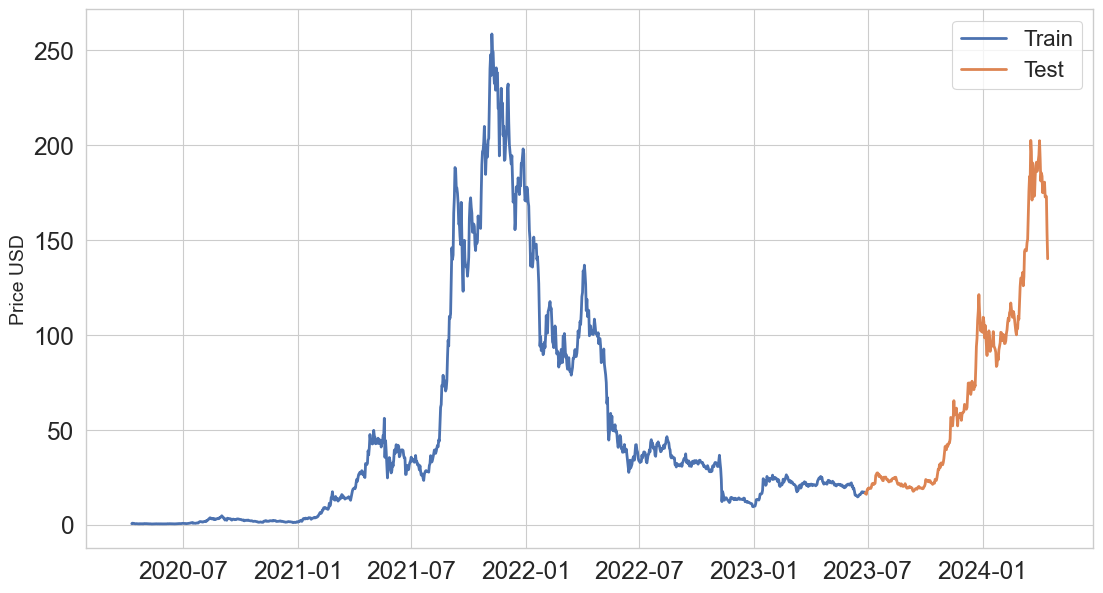

In [52]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(train_data[chosen_col], label='Train', linewidth=2)
ax.plot(test_data[chosen_col], label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [53]:
print(train_data[chosen_col].shape)

(1173,)


In [55]:
datacol = sol.iloc[:, 3:4].values
traincol = train_data.iloc[:, 3:4].values
testcol = test_data.iloc[:, 3:4].values

shaped_data = np.reshape(datacol, (-1,1))
train_shaped = np.reshape(traincol, (-1,1))
test_shaped = np.reshape(testcol, (-1,1))

sc = MinMaxScaler(feature_range=(0,1))
sc.fit(shaped_data)

train_scaled_data = sc.transform(train_shaped)
test_scaled_data = sc.transform(test_shaped)

In [56]:
X = []
y = []
time_steps = 50

for i in range(time_steps, len(train_data)):
    X.append(train_scaled_data[i-time_steps:i,0])
    y.append(train_scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [58]:
model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mse')

In [59]:
callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0224 - val_loss: 0.0021
Epoch 2/100
29/29 [==============================] - 0s 17ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 4/100
29/29 [==============================] - 0s 15ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 5/100
29/29 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 6/100
29/29 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 7/100
29/29 [==============================] - 0s 15ms/step - loss: 0.0017 - val_loss: 9.9724e-04
Epoch 8/100
29/29 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 9.4019e-04
Epoch 9/100
29/29 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 8.8294e-04
Epoch 10/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0014 - val_

In [60]:
X_testing = []
y_testing = []

for i in range(time_steps, len(test_data)):
    X_testing.append(test_scaled_data[i-time_steps:i,0])
    y_testing.append(test_scaled_data[i, 0])

X_testing, y_testing = np.array(X_testing), np.array(y_testing)
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

predicted_price = model.predict(X_testing)
inv_price = sc.inverse_transform(predicted_price)
real_price = np.reshape(y_testing, (-1,1))
real_price = sc.inverse_transform(real_price)

8/8 [==============================] - 0s 6ms/step


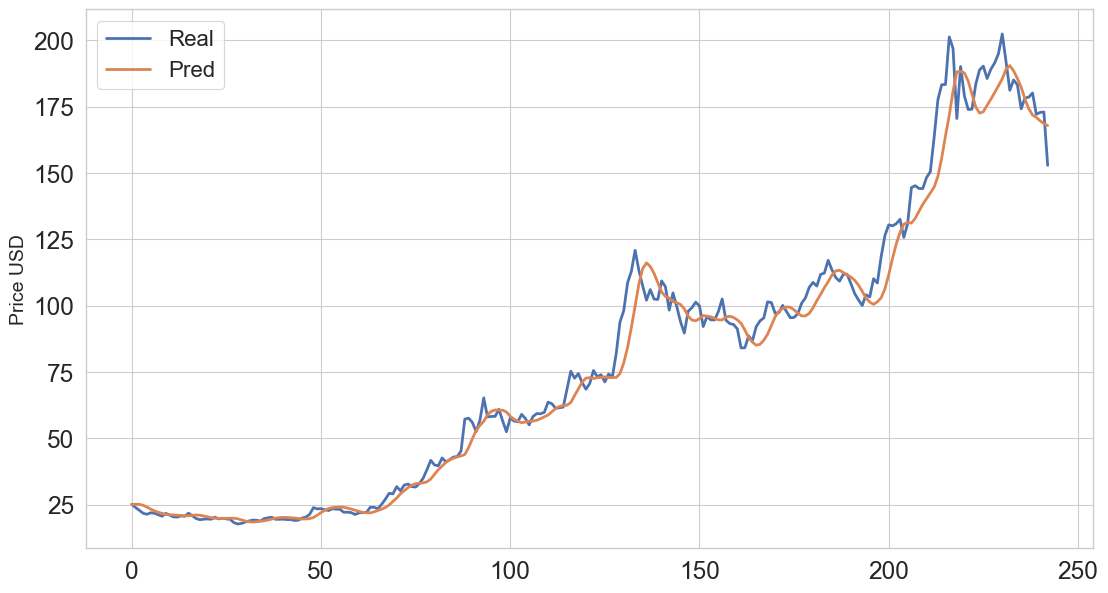

In [61]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(real_price, label='Real', linewidth=2)
ax.plot(inv_price, label='Pred', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [62]:
model.save("crypto_pred.h5")

/Users/moritzrichter/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
from tensorflow import keras
new_model = keras.models.load_model('crypto_pred.h5')

In [64]:
split_row = len(btc) - int(0.2 * len(btc))
train_data = btc.iloc[:split_row]
test_data = btc.iloc[split_row:]
datacol = btc.iloc[:, 3:4].values
traincol = train_data.iloc[:, 3:4].values
testcol = test_data.iloc[:, 3:4].values

shaped_data = np.reshape(datacol, (-1,1))
train_shaped = np.reshape(traincol, (-1,1))
test_shaped = np.reshape(testcol, (-1,1))

sc = MinMaxScaler(feature_range=(0,1))
sc.fit(shaped_data)

train_scaled_data = sc.transform(train_shaped)
test_scaled_data = sc.transform(test_shaped)
X = []
y = []
time_steps = 50

for i in range(time_steps, len(train_data)):
    X.append(train_scaled_data[i-time_steps:i,0])
    y.append(train_scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X_testing = []
y_testing = []

for i in range(time_steps, len(test_data)):
    X_testing.append(test_scaled_data[i-time_steps:i,0])
    y_testing.append(test_scaled_data[i, 0])

X_testing, y_testing = np.array(X_testing), np.array(y_testing)
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))
predicted_price = new_model.predict(X_testing)
inv_price = sc.inverse_transform(predicted_price)
real_price = np.reshape(y_testing, (-1,1))
real_price = sc.inverse_transform(real_price)

10/10 [==============================] - 0s 5ms/step


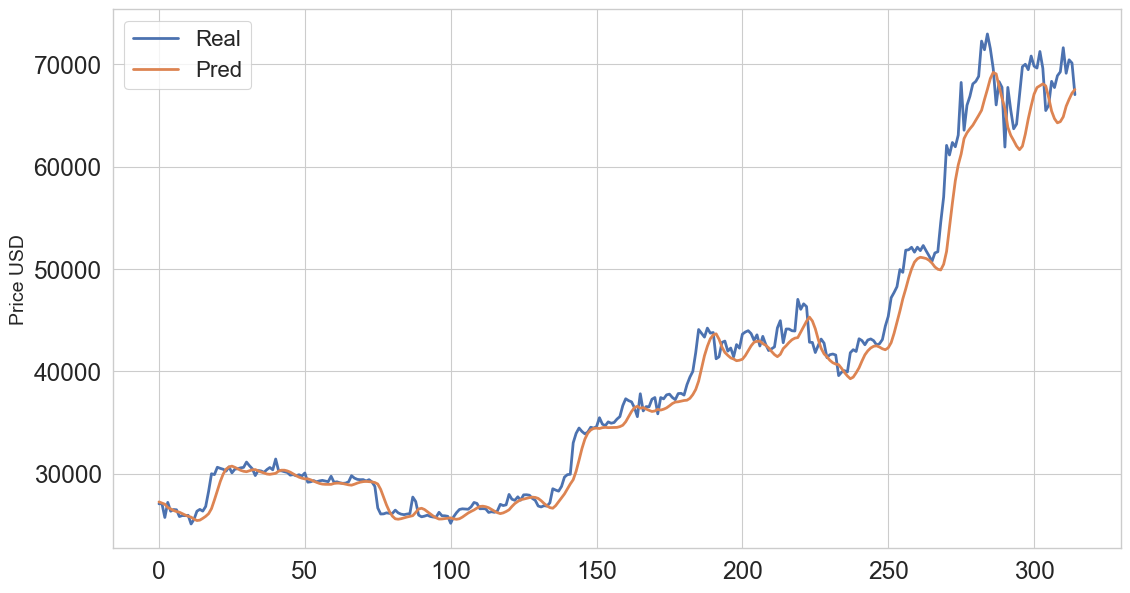

In [65]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(real_price, label='Real', linewidth=2)
ax.plot(inv_price, label='Pred', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)